# Keras tutorial - the Happy House

In this assignment, you will:
1. Learn to use Keras, a high-level neural networks API (programming framework), written in Python and capable of running on top of several lower-level frameworks including TensorFlow and CNTK. 
2. See how you can in a couple of hours build a deep learning algorithm.

Why are we using Keras? Keras is very good for rapid prototyping. In just a short time you will be able to build a model that achieves outstanding results. Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. Being able to go from idea to result with the least possible delay is key to finding good models. However, Keras is more restrictive than the lower-level frameworks, so there are some very complex models that you can implement in TensorFlow but not (without more difficulty) in Keras. That being said, Keras will work fine for many common models. 

In this exercise, you'll work on the "Happy House" problem, which we'll explain below.

## 1 - The Happy House 

For your next vacation, you decided to spend a week with five of your friends from school. It is a very convenient house with many things to do nearby. But the most important benefit is that everybody has commited to be happy when they are in the house. So anyone wanting to enter the house must prove their current state of happiness.

<img src="images/happy-house.jpg" style="width:350px;height:270px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **the Happy House**</center></caption>


As a deep learning expert, to make sure the "Happy" rule is strictly applied, you are going to build an algorithm which that uses pictures from the front door camera to check if the person is happy or not. The door should open only if the person is happy. 

You have gathered pictures of your friends and yourself, taken by the front-door camera. The dataset is labbeled. 

<img src="images/house-members.png" style="width:550px;height:250px;">

Run the following code to normalize the dataset and learn about its shapes.

In [2]:
# load the required packages
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


[1]


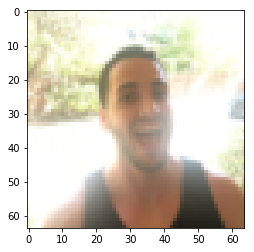

In [14]:
th = 446
imshow(X_train[th])
print(Y_train[th])

In [15]:
image.save_img('./images/446.jpg', X_train[446])

## 2 - Building a model in Keras

Note that Keras uses a different convention with variable names than we've previously used with numpy and TensorFlow. In particular, rather than creating and assigning a new variable on each step of forward propagation such as `X`, `Z1`, `A1`, `Z2`, `A2`, etc. for the computations for the different layers, in Keras code each line above just reassigns `X` to a new value using `X = ...`. In other words, during each step of forward propagation, we are just writing the latest value in the computation into the same variable `X`. The only exception was `X_input`, which we kept separate and did not overwrite, since we needed it at the end to create the Keras model instance (`model = Model(inputs = X_input, ...)` above). 

**Exercise**: Implement a `HappyModel()`. This assignment is more open-ended than most. We suggest that you start by implementing a model using the architecture we suggest, and run through the rest of this assignment using that as your initial model. But after that, come back and take initiative to try out other model architectures. For example, you might take inspiration from the model above, but then vary the network architecture and hyperparameters however you wish. You can also use other functions such as `AveragePooling2D()`, `GlobalMaxPooling2D()`, `Dropout()`. 

**Note**: You have to be careful with your data's shapes. Use what you've learned in the videos to make sure your convolutional, pooling and fully-connected layers are adapted to the volumes you're applying it to.

In [7]:
# Feel free to use the suggested outline in the text above to get started, 
# and run through the whole exercise (including the later portions of this notebook) once. 
# The come back also try out other network architectures as well. 

input_shape = X_train.shape[1:]

# Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
X_input = Input(input_shape)

# Zero-Padding: pads the border of X_input with zeroes
X = ZeroPadding2D((3, 3))(X_input)

# CONV -> BN -> RELU Block applied to X
X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)

# MAXPOOL
X = MaxPooling2D((2, 2), name='max_pool')(X)

# FLATTEN X (means convert it to a vector) + FULLYCONNECTED
X = Flatten()(X)
X = Dense(1, activation='sigmoid', name='fc')(X)

# Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
model = Model(inputs = X_input, outputs = X, name='HappyModel')

In [3]:
Dense?

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).

In [8]:
# To compile the model to configure the learning process. 
# Choose the 3 arguments of `compile()` wisely. 
# Hint: the Happy Challenge is a binary classification problem.
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [9]:
# To train the model. Choose the number of epochs and the batch size.
# Note that if you run fit() again, 
# the model will continue to train with the parameters it has already learnt instead of reinitializing them.
model.fit(x = X_train, y = Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
600/600 [==============================] - 6s 10ms/step - loss: 2.2817 - acc: 0.5667
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 0.3515 - acc: 0.8467
Epoch 3/10
600/600 [==============================] - 7s 12ms/step - loss: 0.1857 - acc: 0.9283
Epoch 4/10
600/600 [==============================] - 8s 13ms/step - loss: 0.1264 - acc: 0.9567
Epoch 5/10
600/600 [==============================] - 8s 13ms/step - loss: 0.1105 - acc: 0.9650
Epoch 6/10
600/600 [==============================] - 8s 13ms/step - loss: 0.1078 - acc: 0.9633
Epoch 7/10
600/600 [==============================] - 8s 13ms/step - loss: 0.1047 - acc: 0.9633
Epoch 8/10
600/600 [==============================] - 8s 13ms/step - loss: 0.0708 - acc: 0.9833
Epoch 9/10
600/600 [==============================] - 7s 12ms/step - loss: 0.0645 - acc: 0.9867
Epoch 10/10
600/600 [==============================] - 7s 12ms/step - loss: 0.0514 - acc: 0.9883


In [17]:
# save the weight of the model and save the model
model.save_weights('./my_weights.hdf5', overwrite=True)
model.save('./my.hdf5', overwrite=True)

In [8]:
# check the hdf5 file which you saved previously 
check_hdf5_file = h5py.File('./my.hdf5', "r")
#train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
print(check_hdf5_file.keys())

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>


In [3]:
from keras.models import load_model
reload_model = load_model('my.hdf5')
preds = reload_model.evaluate(X_test, Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
150/150 [==============================] - 1s 4ms/step

Loss = 0.14186371564865113
Test Accuracy = 0.940000003973643


If your `happyModel()` function worked, you should have observed much better than random-guessing (50%) accuracy on the train and test sets. To pass this assignment, you have to get at least 75% accuracy. 

To give you a point of comparison, our model gets around **95% test accuracy in 40 epochs** (and 99% train accuracy) with a mini batch size of 16 and "adam" optimizer. But our model gets decent accuracy after just 2-5 epochs, so if you're comparing different models you can also train a variety of models on just a few epochs and see how they compare. 

If you have not yet achieved 75% accuracy, here're some things you can play around with to try to achieve it:

- Try using blocks of CONV->BATCHNORM->RELU such as:
```python
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
until your height and width dimensions are quite low and your number of channels quite large (≈32 for example). You are encoding useful information in a volume with a lot of channels. You can then flatten the volume and use a fully-connected layer.
- You can use MAXPOOL after such blocks. It will help you lower the dimension in height and width.
- Change your optimizer. We find Adam works well. 
- If the model is struggling to run and you get memory issues, lower your batch_size (12 is usually a good compromise)
- Run on more epochs, until you see the train accuracy plateauing. 

Even if you have achieved 75% accuracy, please feel free to keep playing with your model to try to get even better results. 

**Note**: If you perform hyperparameter tuning on your model, the test set actually becomes a dev set, and your model might end up overfitting to the test (dev) set. But just for the purpose of this assignment, we won't worry about that here.


## 3 - Conclusion

Congratulations, you have solved the Happy House challenge! 

Now, you just need to link this model to the front-door camera of your house. We unfortunately won't go into the details of how to do that here. 

<font color='blue'>  
**What we would like you to remember from this assignment:**
- Keras is a tool we recommend for rapid prototyping. It allows you to quickly try out different model architectures. Are there any applications of deep learning to your daily life that you'd like to implement using Keras? 
- Remember how to code a model in Keras and the four steps leading to the evaluation of your model on the test set. Create->Compile->Fit/Train->Evaluate/Test.

## 4 - Test with your own image (Optional)

Congratulations on finishing this assignment. You can now take a picture of your face and see if you could enter the Happy House. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right (0 is unhappy, 1 is happy)!
    
The training/test sets were quite similar; for example, all the pictures were taken against the same background (since a front door camera is always mounted in the same position). This makes the problem easier, but a model trained on this data may or may not work on your own data. But feel free to give it a try! 

[[1.]]


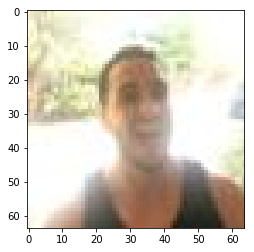

In [4]:
#img = image.load_img('images/my_image.jpg', target_size=(64, 64))
#img = image.load_img('images/443.jpg', target_size=(64, 64))
img = image.load_img('images/446.jpg', target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(reload_model.predict(x))

## 5 - Other useful functions in Keras (Optional)

Two other basic features of Keras that you'll find useful are:
- `model.summary()`: prints the details of your layers in a table with the sizes of its inputs/outputs
- `plot_model()`: plots your graph in a nice layout. You can even save it as ".png" using SVG() if you'd like to share it on social media ;). It is saved in "File" then "Open..." in the upper bar of the notebook.

Run the following code.

In [4]:
reload_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

In [9]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Workspace\\Installed\\Graphviz2.38\\bin'

In [10]:
os.environ["PATH"]

'C:\\ProgramData\\DockerDesktop\\version-bin;C:\\Program Files\\Docker\\Docker\\Resources\\bin;C:\\Workspace\\Installed\\Python\\Python36\\Scripts\\;C:\\Workspace\\Installed\\Python\\Python36\\;C:\\ProgramData\\Oracle\\Java\\javapath;C:\\WINDOWS\\system32;C:\\WINDOWS;C:\\WINDOWS\\System32\\Wbem;C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0\\;C:\\Workspace\\Installed\\TortoiseGit\\bin;C:\\Workspace\\Installed\\Git\\cmd;C:\\Workspace\\Installed\\octave-4.4.1-w64\\bin;C:\\Workspace\\Installed\\Python\\Python27;C:\\Workspace\\Installed\\apache-maven-3.6.0\\bin;C:\\Workspace\\Installed\\cmder\\bin;C:\\Users\\ezxiake\\AppData\\Local\\Microsoft\\WindowsApps;C:\\Users\\ezxiake\\.mxe;c:\\workspace\\installed\\python\\python36\\lib\\site-packages\\numpy\\.libs;c:\\workspace\\installed\\python\\python36\\lib\\site-packages\\scipy\\extra-dll;C:\\Workspace\\Installed\\Graphviz2.38\x08in;C:\\Workspace\\Installed\\Graphviz2.38\\bin'

In [11]:
# Need to download GraphVizk by link below, then add it to the environments path
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html -- 
plot_model(reload_model, to_file='HappyModel.png', show_shapes=True)

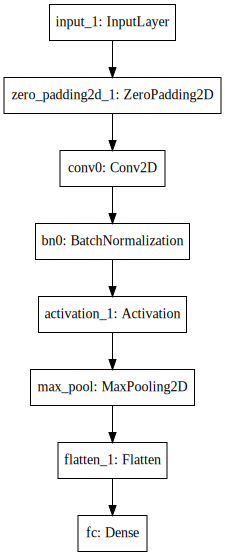

In [12]:
SVG(model_to_dot(reload_model).create(prog='dot', format='svg'))

<https://stackoverflow.com/questions/55049208/error-in-loading-the-model-with-load-weights-in-keras>

一个其他的例子记录下，里面有add 方法，need to 研究

In [ ]:
#https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend
from keras.models import model_from_json
import os



def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# load dataset
dataset = pd.read_csv("joinedRuntime2.csv", index_col='Date', parse_dates=True)

print(dataset.shape)
print(dataset.dtypes)
print(dataset.columns)

# shuffle dataset
df = dataset.sample(frac=1.0)

# split into input (X) and output (Y) variables
X = df.drop(['kWh'],1)
Y = df['kWh']

offset = int(X.shape[0] * 0.7)
X_train, Y_train = X[:offset], Y[:offset]
X_test, Y_test = X[offset:], Y[offset:]


model = Sequential()
model.add(Dense(60, input_dim=7, kernel_initializer='normal', activation='relu'))
model.add(Dense(55, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(45, kernel_initializer='normal', activation='relu'))
model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=[rmse])

# train model
history = model.fit(X_train, Y_train, epochs=5, batch_size=1,  verbose=2)

# plot metrics
plt.plot(history.history['rmse'])
plt.title("kWh RSME Vs Epoch")
plt.show()

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("kwhFinal.h5")
print("[INFO] Saved model to disk")

You are saving the weights, not the whole model. A Model is more than just the weights, including architecture, losses, metrics and etc.

You have two solutions:

1) Go with saving the weights: in this case, in time of model loading, you will need to recreate your model, load the weight and then compile the model. Your code should be something like this:

```python
model = Sequential()
model.add(Dense(60, input_dim=7, kernel_initializer='normal', activation='relu'))
model.add(Dense(55, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(45, kernel_initializer='normal', activation='relu'))
model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.load_weights("kwhFinal.h5")
model.compile(loss='mse', optimizer='adam', metrics=[rmse])
```

2) Save the whole model by this command:

```python
model.save("kwhFinal.h5")
```
And during the loading use this command for having your model loaded:

```python
from keras.models import load_model
model=load_model("kwhFinal.h5")
```